In [1]:
import torch
from torch import nn
from torch.autograd import Function
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""Loading of the dataset"""
print("Loading...")
batch_size = 64

def load_mnist(filename):
    with open(filename, "r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f]
    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)

train = load_mnist('/Users/valentin/Downloads/mnist_background_random/mnist_background_random_train.amat')
test = load_mnist('/Users/valentin/Downloads/mnist_background_random/mnist_background_random_test.amat')

trainset_2 = torch.utils.data.TensorDataset(torch.from_numpy(train[0]).type(torch.FloatTensor), torch.from_numpy(train[1]).type(torch.LongTensor))
testset_2 = torch.utils.data.TensorDataset(torch.from_numpy(test[0]).type(torch.FloatTensor), torch.from_numpy(test[1]).type(torch.LongTensor))

train_loader = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(testset_2, batch_size=batch_size, shuffle=True)
print("fin")

Loading...
fin


Epoch : 0
Test error : 0.19554429631369483
Epoch : 1
Test error : 0.09243917170314057
Epoch : 2
Test error : 0.07424618281587002
Epoch : 3
Test error : 0.06909615076315884
Epoch : 4
Test error : 0.06683850093160287
Epoch : 5
Test error : 0.06578472515193458
Epoch : 6
Test error : 0.06507889119913052
Epoch : 7
Test error : 0.06467675883644479
Epoch : 8
Test error : 0.0643376521315713
Epoch : 9
Test error : 0.06411818191148431
Epoch : 10
Test error : 0.06394071594035597
Epoch : 11
Test error : 0.06378391924857216
Epoch : 12
Test error : 0.06368828394954638
Epoch : 13
Test error : 0.0635748850684793
Epoch : 14
Test error : 0.06350973262328409
Epoch : 15
Test error : 0.06344962405422483
Epoch : 16
Test error : 0.06339638644938884
Epoch : 17
Test error : 0.06334663619700359
Epoch : 18
Test error : 0.06331363205995184
Epoch : 19
Test error : 0.06327009185629417
Epoch : 20
Test error : 0.06323855832645105
Epoch : 21
Test error : 0.06321588979417911
Epoch : 22
Test error : 0.06318502926740287


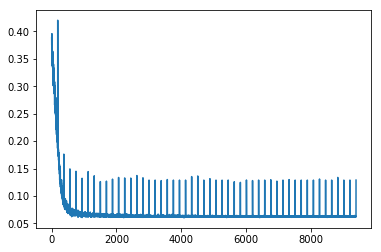

Test Loss


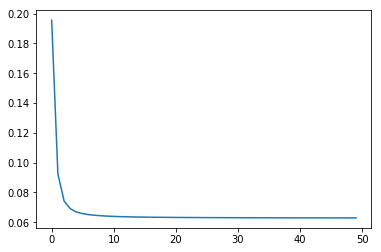

fin


In [12]:
class FLinear(Function):
    """Low level implementation of a linear layer"""
    def __init__(self):
        Function.__init__(self)
            
    def forward(self, x, theta):
        """
        x : B*n
        theta : n*c
        result : B*c
        """
        result = torch.mm(x, theta)
        self.x = x
        self.theta = theta
        return result

    def backward(self, delta):
        """
        delta : B*c (same dimansion as the output of forward)
        output : (B*n, n*c)
        """
        return (torch.mm(delta, torch.t(self.theta)), torch.bmm(self.x.unsqueeze(2), delta.unsqueeze(1)).mean(0, True)[0])
    
class FMSE(Function):
    """Low level implementation of a mean square error layer"""
    def __init__(self):
        Function.__init__(self)
            
    def forward(self, ypred, y):
        """
        y : B*c
        ypred : B*c
        result : B
        """
        self.d = ypred-y
        return (torch.diag(torch.mm(self.d, torch.t(self.d))))/len(y)
        

    def backward(self, delta):
        """
        delta : B*c ((same dimansion as the output of forward)
        output : (B*c, B*c)
        """ 
        return (2*self.d, -2*self.d)
        
class FTanh(Function):
    """Low level implementation of a hyperbolic tangent layer"""
    def __init__(self):
        Function.__init__(self)
            
    def forward(self, x):
        """
        x : B*n
        """
        self.x = x
        self.y = torch.tanh(x)
        return self.y

    def backward(self, delta):
        """
        delta : B*n (same dimansion as the output of forward)
        output : B*n
        """
        return 1-self.y**2
    
def convert(x, y):
    """Convert the output to a onehot vector for classification and change dimension of the input"""
    y_onehot = torch.FloatTensor(batch_size, 10) 
    y_onehot.zero_()
    y_onehot = y_onehot - 1
    y_onehot.scatter_(1, target.view(-1,1), 1)
    x = x.view(-1, 28*28)
    return x, y_onehot

def forward(x, theta, y_onehot):
    z = linear.forward(x, theta)
    ypred = tanh.forward(z)
    err = loss.forward(ypred, y_onehot)
    return err

epsilon = 1e-3#learning rate for gradient descent
nb_epoch = 50#number of epochs
theta = torch.Tensor(28*28, 10).uniform_(-1, 1)#parameters we want to optimize (the one of the linear layer)

"""Layers"""
linear = FLinear()
tanh = FTanh()
loss = FMSE()

list_err = []
list_test = []
nb_it = 0

for j in range(0, nb_epoch):
    print("Epoch : "+str(j))
    for i,(data,target) in enumerate(train_loader): 
        """Train"""
        batch_size = data.size()[0]
        x, y_onehot = convert(data, target)
        """foward"""
        err = forward(x, theta, y_onehot)
        list_err.append(torch.mean(err))
        """backward"""
        dypred, dy = loss.backward(None)
        dz = tanh.backward(dypred)
        dx, dtheta = linear.backward(dz)
        """gradient descent"""
        theta = theta - epsilon*dtheta
    list_test_temp = []
    for i,(data,target) in enumerate(test_loader):
        """Test"""
        batch_size = data.size()[0]
        x, y_onehot = convert(data, target)
        err = forward(data, theta, y_onehot)
        list_test_temp.append(torch.mean(err))
    res_test = sum(list_test_temp)/len(list_test_temp)
    print("Test error : "+str(res_test))
    list_test.append(res_test)
            

print("Train Loss")
plt.plot(np.arange(0, len(list_err)), list_err)
plt.show()
print("Test Loss")
plt.plot(np.arange(0, len(list_test)), list_test)
plt.show()
"""print("Train Accuracy")
plt.plot(np.arange(0, nb_it), list_acc_train)
plt.show()
print("Test Accuracy")
plt.plot(np.arange(0, nb_it), list_acc_test)
plt.show()"""
      
print("fin")
#x[j] = x[j].cuda()
#y[j] = y[j].cuda